# Sentiment Analysis with RNN

## Setup

In [198]:
import numpy as np
import pandas as pd
import preprocessor as tp
import torch
import torchtext
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import torchtext

from nltk.stem import WordNetLemmatizer
from nltk.tokenize import TweetTokenizer
from sklearn import metrics
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

## Preprocess

Read raw data, source https://www.kaggle.com/datasets/kazanova/sentiment140/data.

Here we use "latin-1" for encoding as not all text are "utf-8" encoded, we also need to add the column names which is not provided in original dataset.

In [156]:
#csv file not included in the repo
df = pd.read_csv('training_sent.csv' , encoding='latin-1', names=['target', 'id', 'date', 'flag', 'user', 'text'])

In [157]:
df.head()

,target,id,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


### Clean data

In [158]:
df.flag.value_counts()

NO_QUERY    1600000
Name: flag, dtype: int64

In [159]:
df.target.value_counts()

0    800000
4    800000
Name: target, dtype: int64

Remove useless features.

In [160]:
df_pre = df.drop(['id', 'date', 'flag', 'user'], axis=1)

Re-categorize the label, 0 for "negative" and 1 for "positive".

In [161]:
df_pre['target'] = df_pre['target'].replace(4, 1)

In [162]:
df_pre.head()

,target,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


### Preprocess tweet

1. Use Twitter-Processor to clean the tweet, including URL/mention/hashtag removing.

In [163]:
def preprocess_tweet(text):
    text = tp.clean(text)
    return text

In [164]:
df_pre['clean_text'] = df_pre['text'].apply(preprocess_tweet)

In [165]:
df_pre.loc[:,['text', 'clean_text']].head()


,text,clean_text
0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...","- Awww, that's a bummer. You shoulda got David..."
1,is upset that he can't update his Facebook by ...,is upset that he can't update his Facebook by ...
2,@Kenichan I dived many times for the ball. Man...,I dived many times for the ball. Managed to sa...
3,my whole body feels itchy and like its on fire,my whole body feels itchy and like its on fire
4,"@nationwideclass no, it's not behaving at all....","no, it's not behaving at all. i'm mad. why am ..."


2. Lowercase the text, remove punctuation, extra space and digits.

In [166]:
df_pre['clean_text'] = df_pre['clean_text'].str.lower().str.replace('[^\w\s]',' ').str.replace('\s\s+', ' ').str.replace('\d+[kKmM]*', '')

/var/folders/dv/jgp81_zd7q112t2sf_4ppk5r0000gn/T/ipykernel_91032/999242078.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  df_pre['clean_text'] = df_pre['clean_text'].str.lower().str.replace('[^\w\s]',' ').str.replace('\s\s+', ' ').str.replace('\d+[kKmM]*', '')


3. Lemmatize and tokenize the text.

In [167]:
lemmatizer = WordNetLemmatizer()
w_tokenizer = TweetTokenizer()

In [168]:
def lemmatize_tweet(row):
    text = row['clean_text']
    return [(lemmatizer.lemmatize(w)) for w in \
                                     w_tokenizer.tokenize((text))]

In [169]:
df_pre['clean_text'] = df_pre.apply(lemmatize_tweet, axis=1)

In [170]:
df_pre.loc[:,['text', 'clean_text']].head()

,text,clean_text
0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...","[awww, that, s, a, bummer, you, shoulda, got, ..."
1,is upset that he can't update his Facebook by ...,"[is, upset, that, he, can, t, update, his, fac..."
2,@Kenichan I dived many times for the ball. Man...,"[i, dived, many, time, for, the, ball, managed..."
3,my whole body feels itchy and like its on fire,"[my, whole, body, feel, itchy, and, like, it, ..."
4,"@nationwideclass no, it's not behaving at all....","[no, it, s, not, behaving, at, all, i, m, mad,..."


### Feature augmentation

Add the size of tokens for later training.

In [172]:
df_pre['text_len'] = df_pre['clean_text'].apply(len)

In [173]:
df_pre = df_pre[df_pre.text_len != 0]

### Create vocabulary

Create custome dataset.

In [174]:
class CustomDataset(Dataset):
    def __init__(self, dataframe):
        self.labels = dataframe['target']
        self.tokens = dataframe['clean_text']

    def __len__(self):
        return len(self.tokens)

    def __getitem__(self, idx):
        text = self.tokens.iloc[idx]
        label = self.labels.iloc[idx]
        return text, label

Split the data into train and test(validation) set.

In [175]:
train, test = train_test_split(df_pre, test_size=0.2, shuffle=True, random_state=0)

In [176]:
train_data = CustomDataset(train)
test_data = CustomDataset(test)

In [177]:
len(max(df_pre['clean_text'], key=len))

53

Create the vocabulary from training data, only tokens with frequency > 10 are selected(to reduce training effort), add unique and padding tokens.

In [193]:
vocabulary = torchtext.vocab.build_vocab_from_iterator(
    train["clean_text"],
    min_freq=10,
    specials=["<unk>", "<pad>"],
)
vocabulary.set_default_index(vocabulary["<unk>"])

print("Number of tokens: {}".format(len(vocabulary)))

Number of tokens: 26193


### Numericalization

Convert text tokens to indices, add padding to provide a constant length for all according to the maximum length.

In [179]:
max_length = 53
padding_idx = vocabulary["<pad>"]

In [180]:
def sequence(tokens):
    idx = vocabulary.lookup_indices(tokens)
    if len(idx) < max_length:
        idx = idx + [padding_idx] * max(0, max_length - len(idx))
    return idx
    

In [194]:
train['text_seq'] = train['clean_text'].apply(sequence)
test['text_seq'] = test['clean_text'].apply(sequence)

## Train

In [182]:
if torch.cuda.is_available():
    device = torch.device("cuda") 
else:
    device = torch.device("cpu")
device

device(type='cpu')

In [196]:
x_train = np.array([np.array(x) for x in train['text_seq'].values])
x_test = np.array([np.array(x) for x in test['text_seq'].values])

Create dataloader with (token sequence, token original length, and label).

In [197]:
batch_size = 256

train_loader = DataLoader(list(zip(x_train, train['text_len'].values, train['target'].values)), shuffle=True, batch_size=batch_size)
test_loader = DataLoader(list(zip(x_test, test['text_len'].values, test['target'].values)), shuffle=False, batch_size=batch_size)

Training and validation functions, with reference to notebooks in class.

In [185]:
def train_epoch(model, loader, optimizer, criterion):
    
    # Initialize epoch loss (cummulative loss fo all batchs)
    epoch_loss = 0.0

    for batch_idx, batch in enumerate(loader):
            
            X_batch, x_len, y_batch = batch   

            log_probs = model(X_batch, x_len)        

            # Calculate loss
            loss = criterion(log_probs, y_batch)
            
            ### Pytorch magic! ###
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Keep track of overall epoch loss
            epoch_loss += loss.item()   
            
    return epoch_loss

In [199]:
def evaluate(model, loader, plot=False):
    
    y_true, y_pred = [], []
    
    for batch_idx, batch in enumerate(loader):
            
        X_batch, x_len, y_batch = batch
        
        
        log_probs = model(X_batch, x_len)                

        y_batch_pred = torch.argmax(log_probs, dim=1)

        y_true += list(y_batch.cpu())
        y_pred += list(y_batch_pred.cpu())
        
    # Plot confusion matrix at the last epoch
    if plot:
        confusion_matrix = metrics.confusion_matrix(y_true, y_pred)
        cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix,  display_labels = ["negative", "positive"])
        cm_display.plot()
        plt.show()
    return metrics.f1_score(y_true, y_pred, average='micro')

In [188]:
def training(model, loader_train, loader_test, optimizer, criterion, num_epochs):
    
    results = []
    
    print("Total Training Time (total number of epochs: {})".format(num_epochs))
    for epoch in range(1, num_epochs+1):        
        model.train()
        epoch_loss = train_epoch(model, loader_train, optimizer, criterion)
        model.eval()
        acc_train = evaluate(model, loader_train)
        plot = False
        if epoch == num_epochs:
            plot = True
        acc_test = evaluate(model, loader_test, plot)

        results.append((epoch_loss, acc_train, acc_test))
        
        #if epoch % 10 == 0:
        print("[Epoch {}] loss:\t{:.3f}, f1 train: {:.3f}, f1 test: {:.3f} ".format(epoch, epoch_loss, acc_train, acc_test))
            
    return results

Load pretrained embedding vectors "English Wikipedia Dump of February 2017", source http://vectors.nlpl.eu/repository/.

In [200]:
# embedding vectors file not included in the repo
pretrained_vectors = torchtext.vocab.Vectors("5/model.txt")
pretrained_embedding = pretrained_vectors.get_vecs_by_tokens(vocabulary.get_itos())

Define the model structure.

In [201]:
class LSTM(nn.Module):
    def __init__(
        self,
        embedding_dim,
        hidden_size,
        vocab_size,
        output_size,
        padding_idx,
    ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=padding_idx)
        self.lstm = nn.LSTM(
            embedding_dim,
            hidden_size,
            2,
            bidirectional=True,
            dropout=0.5,
            batch_first=True,
        )
        self.fc = nn.Linear(hidden_size * 2, output_size)
        self.dropout = nn.Dropout(0.5)

    def forward(self, ids, length):
        # print(length.shape, ids.shape)
        embedded = self.dropout(self.embedding(ids))
        packed_embedded = nn.utils.rnn.pack_padded_sequence(
            embedded, length, batch_first=True, enforce_sorted=False
        )
        packed_output, (hidden, cell) = self.lstm(packed_embedded)
        output, output_length = nn.utils.rnn.pad_packed_sequence(packed_output)
        hidden = self.dropout(torch.cat([hidden[-1], hidden[-2]], dim=-1))
        prediction = self.fc(hidden)
        return prediction

In [202]:
lstm = LSTM(embedding_dim=300, hidden_size=64, vocab_size=len(vocabulary), output_size=2, padding_idx=padding_idx)
optimizer = optim.Adam(lstm.parameters(), lr=1e-4)
#criterion = nn.NLLLoss()
# weight_i = total_samples / (num_samples_in_i * output_size)
#weights = [0.34, 32.78, 24.87]
#weights = [0.01, 45, 55]
#class_weights = torch.FloatTensor(weights)
#criterion = nn.CrossEntropyLoss(weight=class_weights)
criterion = nn.CrossEntropyLoss()
lstm.embedding.weight.data = pretrained_embedding
#lstm.embedding.weight.requires_grad = False
lstm.to(device)

LSTM(
  (embedding): Embedding(26193, 300, padding_idx=1)
  (lstm): LSTM(300, 64, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [203]:
num_epochs = 10
results = training(lstm, train_loader, test_loader, optimizer, criterion, num_epochs)

Total Training Time (total number of epochs: 10)
[Epoch 1] loss:	2336.732, f1 train: 0.810, f1 test: 0.805 
[Epoch 2] loss:	2117.424, f1 train: 0.817, f1 test: 0.810 
[Epoch 3] loss:	2035.945, f1 train: 0.824, f1 test: 0.816 
[Epoch 4] loss:	1979.234, f1 train: 0.830, f1 test: 0.819 
[Epoch 5] loss:	1936.770, f1 train: 0.834, f1 test: 0.821 
[Epoch 6] loss:	1902.875, f1 train: 0.837, f1 test: 0.823 


KeyboardInterrupt: 

Total Training Time (total number of epochs: 1)


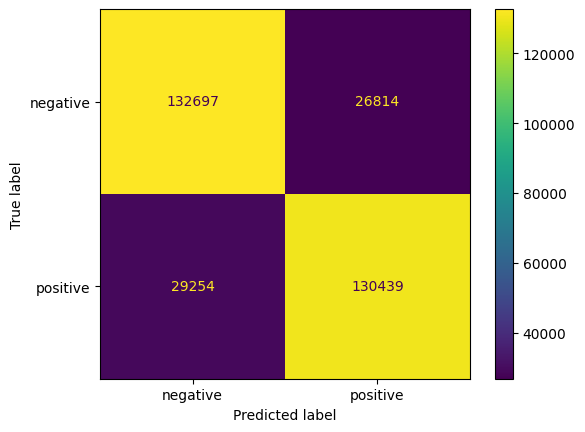

[Epoch 1] loss:	1875.303, f1 train: 0.840, f1 test: 0.824 


In [209]:
new_results = training(lstm, train_loader, test_loader, optimizer, criterion, 1)

Save trained model, vocabulary and processed data.

In [204]:
torch.save(vocabulary, 'vocab.pth')

In [208]:
# not included in the repo
df_pre.drop(['text'], axis=1).to_csv("pre.csv", encoding='utf-8', index=False)

In [210]:
torch.save(lstm.state_dict(), 'lstm.pt')

## Test

Some test tweets from Elon Musk that was acknowledged by public to have impact on cryptocurrency's price.

In [244]:
test = ["You can now buy a Tesla with bitcoin",
        "Tesla would trial run accepting DOGE for merchandise",
        "Tesla buys $1.5 billion in bitcoin",
        "Tesla would no longer accept BTC as payment",
        "Tesla will make some merch buyable with Doge & see how it goes",
        "Doge",
        "Ur welcome",
        "Working with Doge devs to improve system transaction efficiency. Potentially promising",
        "Important to support",
        "Tesla has suspended vehicle purchases using Bitcoin. We are concerned about rapidly increasing use of fossil fuels for Bitcoin mining and transactions, especially coal, which has the worst emissions of any fuel. Cryptocurrency is a good idea on many levels and we believe it has a promising future, but this cannot come at great cost to the environment. Tesla will not be selling any Bitcoin and we intend to use it for transactions as soon as mining transitions to more sustainable energy. We are also looking at other cryptocurrencies that use <1 of Bitcoin's energy/transaction."]

Transfer the raw text to dataframe.

In [245]:
df_test = pd.DataFrame({'text':test})

In [251]:
len(max(df_test['clean_text'], key=len))

96

In [252]:
max_length = 96

Preprocess the test data.

In [253]:
df_test['clean_text'] = df_test['text'].apply(preprocess_tweet)
df_test['clean_text'] = df_test['clean_text'].str.lower().str.replace('[^\w\s]',' ').str.replace('\s\s+', ' ').str.replace('\d+[kKmM]*', '')
df_test['clean_text'] = df_test.apply(lemmatize_tweet, axis=1)
df_test['text_len'] = df_test['clean_text'].apply(len)
df_test['text_seq'] = df_test['clean_text'].apply(sequence)

/var/folders/dv/jgp81_zd7q112t2sf_4ppk5r0000gn/T/ipykernel_91032/3677494937.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df_test['clean_text'] = df_test['clean_text'].str.lower().str.replace('[^\w\s]',' ').str.replace('\s\s+', ' ').str.replace('\d+[kKmM]*', '')


In [254]:
df_test.head()

,text,clean_text,text_len,text_seq
0,You can now buy a Tesla with bitcoin,"[you, can, now, buy, a, tesla, with, bitcoin]",8,"[9, 32, 31, 396, 5, 16698, 24, 0, 1, 1, 1, 1, ..."
1,Tesla would trial run accepting DOGE for merch...,"[tesla, would, trial, run, accepting, doge, fo...",8,"[16698, 120, 4030, 433, 6642, 0, 12, 15711, 1,..."
2,Tesla buys $1.5 billion in bitcoin,"[tesla, buy, billion, in, bitcoin]",5,"[16698, 396, 5518, 11, 0, 1, 1, 1, 1, 1, 1, 1,..."
3,Tesla would no longer accept BTC as payment,"[tesla, would, no, longer, accept, btc, a, pay...",8,"[16698, 120, 41, 770, 2897, 0, 5, 4711, 1, 1, ..."
4,Tesla will make some merch buyable with Doge &...,"[tesla, will, make, some, merch, buyable, with...",12,"[16698, 61, 98, 71, 6944, 0, 24, 0, 70, 73, 6,..."


In [256]:
x_test_e = np.array([np.array(x) for x in df_test['text_seq'].values])

Apply the model.

In [257]:
y_pred = lstm(torch.from_numpy(x_test_e), df_test['text_len'].values)                

df_test['label'] = torch.argmax(y_pred, dim=1)


Convert the predicted label to categorical features.

In [258]:
df_test['label'] = df_test['label'].replace(0, 'negative')
df_test['label'] = df_test['label'].replace(1, 'positive')

In [259]:
df_test.loc[:,['text', 'label']]

,text,label
0,You can now buy a Tesla with bitcoin,positive
1,Tesla would trial run accepting DOGE for merch...,positive
2,Tesla buys $1.5 billion in bitcoin,positive
3,Tesla would no longer accept BTC as payment,negative
4,Tesla will make some merch buyable with Doge &...,positive
5,Doge,positive
6,Ur welcome,positive
7,Working with Doge devs to improve system trans...,positive
8,Important to support,positive
9,Tesla has suspended vehicle purchases using Bi...,negative


Overall, the test results are quite impressive, none of the selected tweet is predicted wrongly.